本例中使用了还在开发中的relax，如果环境中已经安装配置了tvm，可能会发生冲突，建议到google colab中执行
<a href="https://colab.research.google.com/drive/1vOt77ugt1AhmhufUyw-bW8emIwh0fXqN#scrollTo=PW18qc_faMIC" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 端到端模型执行

- 关注元张量函数，讨论如何构建端到端模型


## 环境，数据集及模型参数准备

In [16]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels


In [17]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [18]:
# 加载数据集
# 使用fashion MNIST数据集上的一个模型 
# 以下代码从 torchvision 下载并准备数据并转换成NumPy数组。
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

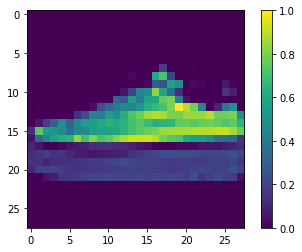

Class: Sneaker


In [19]:
# 绘制我们希望能预测的图像
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

In [20]:
# 下载模型参数
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-08-23 10:13:58--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-08-23 10:13:58--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl.1’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.04s   

2022-08-23 10:13:59 (10.8 MB/s) - ‘fasionmnist_mlp_params

## 端到端模型整合

例子：一个两层神经网络，由两个全连接层和一个有 relu 激活层组成。为了简化问题，我们删除了最终的 softmax 层。输出分数是未标准化的，但最大值仍然对应于最可能的类别。


In [21]:
# 1.numpy实现
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[-18.002035  -26.690979  -14.855994  -17.64491   -21.919956   -3.1951513
  -18.476469   17.237576   -0.7316637 -11.115718 ]]
[7]
NumPy-MLP Prediction: Sneaker


In [22]:
# 2.low-level numpy 实现
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Sneaker


### 在TVMScript中构建端到端IRModule
- 参考Numpy代码，用MLC抽象实现端到端模型运行

- R.function 为relax函数。relax函数是一种表示上层神经网络执行的全新抽象

In [23]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                B: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out
# print(MyModule.script())

- 使用计算图来可视化高层模型执行
  - 图中的框表示计算操作
  - 箭头对应于中间张量的输入输出

- 计算图通常具有的特性：
  - 框的每个输入边对应操作的输入
  - 每个出边对应于操作的输出
  - 每个操作可以任意重新排序，直到边缘的拓扑排序

- call_tir
  - R.call_tir是引入元张量函数的过程。
  - 将输入(n)和输出(1)传递给prim_func。 执行prim_func后，结果会填充到输出中。
  - 目标传递风格：
    - 输入和输出在外部显式分配并传递给底层函数，常用于底层库设计，便于高层框架处理内存分配决策。
    - 适用于<font color=red>输出固定</font>的张量操作。
  - 对于计算图的特性来说
    - 我们要隐藏可能的分配或对函数的显式写入，及pure或side-effect free。
    - 如果一个函数只从其输入中读取并通过其输出返回结果，它不会改变程序的其他部分（例如递增全局计数器），那么它是pure或side-effect free的。
    - call_tir使我们能隐藏调用低层元函数细节，并将它们应用到计算图中。

- 实际上，最底层的实现会有显式的内存分配，所以call_tir主要是为了让我们在生成实际实现之前继续做一些高层的转换。

In [24]:
# 与之相对应的low-level numpy实现
def lnumpy_call_tir(prim_func, inputs, shape, dtype):
    res = np.empty(shape, dtype=dtype)
    prim_func(*inputs, res)
    return res

def lnumpy_mlp_with_call_tir(data, w0, b0, w1, b1):
    lv0 = lnumpy_call_tir(lnumpy_linear0, (data, w0, b0), (1, 128), dtype="float32")
    lv1 = lnumpy_call_tir(lnumpy_relu0, (lv0, ), (1, 128), dtype="float32")
    out = lnumpy_call_tir(lnumpy_linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    return out

result = lnumpy_mlp_with_call_tir(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = np.argmax(result, axis=1)
print("Low-level Numpy with CallTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with CallTIR Prediction: Sneaker


- Dataflow Block
  - R.dataflow() 范围标注，是用来标记程序计算图区域的一种方式
  - 在dataflow block中，所有操作都需要side-effect free；而dataflow block外，操作可能包含side-effect。
    - 例如在R.dataflow()前用R.alloc_tensor创建一个张量，这个张量可以与main的参数张量一同使用。
    - 本课的大部分课程只会处理计算图。

## 构建并运行模型
！注意：relax仍在开发中，因此某些API可能会更改
- 使用relax.vm.build构建该函数
  - 构建一个“可执行文件”。区别于传统操作系统中的可执行文件，不能直接在系统中运行，而是针对Relax VM设计的一种文件格式。

In [25]:
# 使用realx.vm.build构建一个可执行文件
ex = relax.vm.build(MyModule, target="llvm")
print(type(ex))

# 初始化一个虚拟机执行器，用来运行该函数
vm = relax.VirtualMachine(ex, tvm.cpu())  # tvm.cpu()指示我们要在哪个设备上运行端到端执行。

# 运行
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)

<class 'tvm.relax.vm.Executable'>
[[-18.002035  -26.690985  -14.8559885 -17.64491   -21.919956   -3.1951506
  -18.476469   17.237574   -0.731666  -11.115719 ]]


In [26]:
# 将结果转成numpy数组，并调用argmax获取类标签。
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Sneaker


## 在环境中集成现有运行库
将现有的库函数集成到 MLC 过程中

In [27]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

### 注册运行时函数
- DLPack 是一种通用的交换标准，允许不同的框架交换 Tensor/NDArray 而无需参与数据复制。

- from_dlpack 是一个零拷贝转换，torch阵列和TVM NDArray共享底层内存。

- from_dlpack API 由多个框架支持，是 Python 数组 API 标准的一部分。 如果您有兴趣，可以阅读更多 [这里](https://dmlc.github.io/dlpack/latest/python_spec.html)。

In [28]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

### build and run

In [29]:
ex = relax.vm.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: Sneaker


### 混合起来(TensorIR实现和库实现)

In [30]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

ex = relax.vm.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Sneaker


## 参数绑定到IRModule
之前的示例中，通过显式传递参数来构造主函数。将参数绑定为附加到IRModule的常量会降低API的复杂度。


In [33]:
# 以下代码通过将参数名称与 nd_params 中的键匹配来创建绑定。
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
print(MyModuleWithParams.script())
# IPython.display.Code(MyModuleWithParams.script(), language="python")

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: Tensor((1, 784), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, meta[relay.Constant][0], meta[relay.Constant][1]), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, meta[relay.Constant][2], meta[relay.Constant][3]), (1, 10), dtype="float32")
            R.output(out)
        return out
    
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y")

在上面的脚本中，meta[relay.Constant][0] （译者注：目前 Relax 的常量表达依然继承自 Relay ，未来该 API 可能会更改） 对应于一个存储常量的隐式字典（它没有显示为脚本的一部分，但仍然是 IRModule 的一部分）。 如果我们构建转换后的 IRModule，我们现在可以通过传入输入数据来调用该函数。

In [34]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Sneaker
